# GT5 (7 months test data, 12 months train data)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
from statistics import stdev

In [3]:
# Loading test output from the model and converting to time index

filename = r'Brunei_Champion_GT5_tst_pred_01Dec2018_01Jul2019.csv'

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(filename, parse_dates = ['timestamp'], date_parser = dateparse)
df.set_index('timestamp', inplace = True)
df['date'] = df.index


In [4]:
# Changing -1 to 1 and 1 to 0 [1 denotes anomaly, 0 denotes normal]

df.prediction = df.prediction.replace(1, 0)
df.prediction = df.prediction.replace(-1, 1)

df['anomaly'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 1), 'anomaly'] = 1

df['normal'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 0), 'normal'] = 1

df['sys_status'] = 0
df.loc[(df['system_status'] == 'online'), 'sys_status'] = 1
df.loc[(df['system_status'] == 'offline'), 'sys_status'] = 0

df['flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 1) & (df['prediction'] == 1), 'flips'] = 1


In [6]:
## Creating results dataframe

resultsdf = df[['anomaly','flips','normal','sys_status']].resample('W').sum()
resultsdf.columns = ['anomaly_count','flips_count', 'model_uptime_count','online_status_count']


x = df[['prediction', 'sys_status']].resample('W').count()

resultsdf['Total_counts'] = x['prediction']

resultsdf['anomaly_ratio'] = resultsdf['anomaly_count'] / resultsdf['Total_counts']
resultsdf['flips_ratio'] = resultsdf['flips_count'] / resultsdf['Total_counts']
resultsdf['model_uptime_ratio'] = resultsdf['model_uptime_count'] / resultsdf['Total_counts']
resultsdf ['machine availability'] =  (resultsdf['online_status_count']/ (x['sys_status'])) * 100


In [7]:
#resultsdf.drop(resultsdf.tail(1).index, inplace = True)

len(resultsdf)   

32

In [8]:
#Bifurcate the test data

resultsdf1 = resultsdf.head(27)
resultsdf2 = resultsdf.tail(4)

In [9]:
n = len(resultsdf1)

A = [np.mean(resultsdf1['anomaly_ratio']), np.mean(resultsdf1['flips_ratio']), np.mean(resultsdf1['model_uptime_ratio'])]
S = [stdev(resultsdf1['anomaly_ratio']), stdev(resultsdf1['flips_ratio']), stdev(resultsdf1['model_uptime_ratio'])]

dff = pd.DataFrame(columns = ['Weeks', 'Metrics', 'Average', 'Standard Deviation'])

df1 = dff.append({'Weeks':n, 'Metrics':'Anomaly Ratio', 'Average': A[0], 'Standard Deviation':S[0]}, ignore_index = True)
df2 = df1.append({'Weeks':n, 'Metrics':'Flips Ratio', 'Average':A[1], 'Standard Deviation':S[1]}, ignore_index = True)   
df0 = df2.append({'Weeks':n, 'Metrics':'Model Uptime Ratio', 'Average':A[2], 'Standard Deviation':S[2]}, ignore_index = True)

df0

,Weeks,Metrics,Average,Standard Deviation
0,27,Anomaly Ratio,0.073009,0.178777
1,27,Flips Ratio,0.001874,0.003473
2,27,Model Uptime Ratio,0.620701,0.458069


In [10]:
n = len(resultsdf2)

A1 = [np.mean(resultsdf2['anomaly_ratio']), np.mean(resultsdf2['flips_ratio']), np.mean(resultsdf2['model_uptime_ratio'])]
S1 = [stdev(resultsdf2['anomaly_ratio']), stdev(resultsdf2['flips_ratio']), stdev(resultsdf2['model_uptime_ratio'])]


In [11]:
a = [A[0] - A1[0], A[1] - A1[1], A[2] - A1[2]]
s = [S[0] - S1[0], S[1] - S1[1], S1[2] - S1[2]]

In [12]:
#real data
#threshold to be set on effect sizes

dff = pd.DataFrame(columns = ['Weeks', 'Metrics', 'Average', 'Standard Deviation', 'Effect size (SD)', 'Effect size (mean)'])

df1 = dff.append({'Weeks':n, 'Metrics':'Anomaly Ratio', 'Average':A1[0], 'Standard Deviation':S1[0], 'Effect size (SD)': s[0], 'Effect size (mean)': a[0]}, ignore_index = True)
df2 = df1.append({'Weeks':n, 'Metrics':'Flips Ratio', 'Average':A1[1], 'Standard Deviation':S1[1], 'Effect size (SD)' : s[1], 'Effect size (mean)': a[1]}, ignore_index = True)   
dfdiff = df2.append({'Weeks':n, 'Metrics':'Model Uptime Ratio', 'Average':A1[2], 'Standard Deviation':S1[2], 'Effect size (SD)': s[2], 'Effect size (mean)': a[2]}, ignore_index = True)

dfdiff

,Weeks,Metrics,Average,Standard Deviation,Effect size (SD),Effect size (mean)
0,4,Anomaly Ratio,0.953621,0.046907,0.131870,-0.880613
1,4,Flips Ratio,0.010417,0.008515,-0.005042,-0.008543
2,4,Model Uptime Ratio,0.041419,0.046095,0.000000,0.579282


<IPython.core.display.Javascript object>


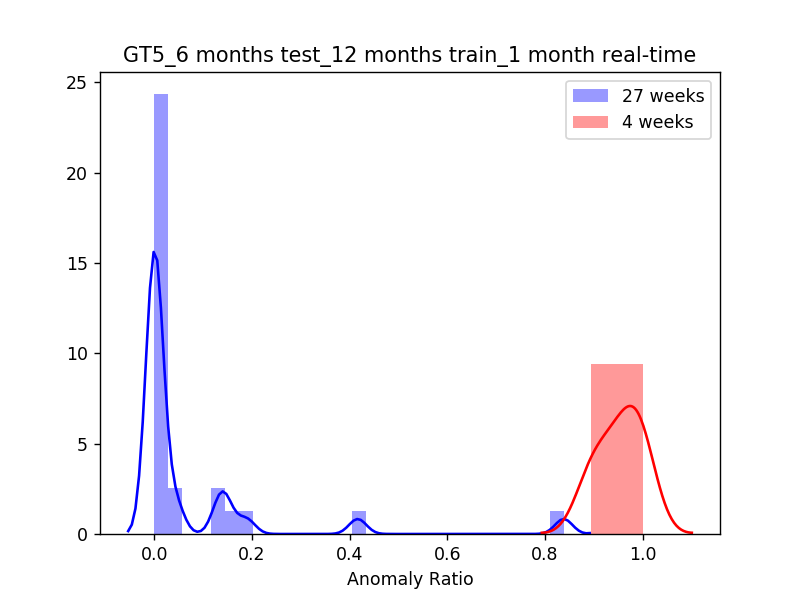

In [18]:
%matplotlib notebook

ax = sns.distplot(resultsdf1['anomaly_ratio'], color = "b", label = '27 weeks')
ax = sns.distplot(resultsdf2['anomaly_ratio'], color = 'r', label = '4 weeks')
plt.title('GT5_6 months test_12 months train_1 month real-time')
plt.xlabel('Anomaly Ratio')

ax.legend()